In [1]:
import pandas as pd
import numpy as np
from modules import data_sampling, SimRank, evaluation, BenchMark
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import random
#random.seed(0)

# Loading & Manipulating Data

In [4]:
# Load data
ratings_raw = pd.read_csv('ratings.csv')
tags_raw = pd.read_csv('genome-scores.csv')

In [5]:
# Keep movies have tags
# set threhod when using jaccard sim
# tags = tags[tags.relevance > 0.5]

ratings, tags = data_sampling.align_items(ratings_raw, tags_raw)

random split

In [6]:
rating_sample = data_sampling.sample_df(ratings, user_thresh=0, item_thresh = 20, user_sample_n = 6000, item_sample_n = 3100, random_seed = 42)


number of users: 6000
number of items: 3014
number of ratings: 250592


In [7]:
# Train test split
rating_train, rating_test = train_test_split(rating_sample, test_size=0.20, random_state=42)

In [8]:
user_grouped_sample = evaluation.group(rating_sample, to_group = 'user')

by timestamp

# Descriptive Analysis

In [8]:
def plot_df(user_freq, movie_freq, user_cnt, movie_cnt, user_grouped, movie_grouped):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
    ax1, ax2, ax3, ax4 = axes.ravel()
    sns.set(style="ticks")
    sns.despine(fig=fig)

    sns.distplot(user_freq, kde=False, norm_hist=False, bins=1000, ax=ax1)
    ax1.set_xlim([0, 400])
    ax1.set_xlabel(None)

    ax1.set_title('#Ratings Across Users', size=15)
    sns.distplot(movie_freq, kde=False, norm_hist=False, bins=5000, ax=ax2)
    ax2.set_xlim([0, 200])
    ax2.set_xlabel(None)
    ax2.set_title('#Ratings Across Movies', size=15)


    groupIds = sorted(user_grouped.groupId.unique())
    groupRanges = [user_grouped[user_grouped.groupId==groupId].groupRange.unique()[0] for groupId in groupIds]

    sns.barplot(x=user_cnt['groupId'], y=user_cnt['count'], ax=ax3)
    ax3.set_xticklabels(groupRanges )  #['0-5', '5-10', '10-50', '50-100', '100-500', '500-1k', '1k-10k', '10k-100k'] 
    ax3.set_xlabel(None)

    groupIds = sorted(movie_grouped.groupId.unique())
    groupRanges = [movie_grouped[movie_grouped.groupId==groupId].groupRange.unique()[0] for groupId in groupIds]

    sns.barplot(x=movie_cnt['groupId'], y=movie_cnt['count'], ax=ax4)
    ax4.set_xticklabels(groupRanges )  #['0-5', '5-10', '10-50', '50-100', '100-500', '500-1k', '1k-10k', '10k-100k'] 
    ax4.set_xlabel(None)

    plt.tight_layout()
    plt.show()

In [9]:
user_freq_sample = rating_sample.groupby('userId').count()['movieId']
print("Number of users: ", len(user_freq_sample))
movie_freq_sample = rating_sample.groupby('movieId').count()['userId']
print("Number of movies: ", len(movie_freq_sample))

Number of users:  6000
Number of movies:  3014


In [17]:
#describe sample dataset
user_cnt_sample = user_grouped_sample.groupby(['groupId', 'groupRange']).count().rename(columns={"userId":"count"}).reset_index()
movie_grouped_sample = evaluation.group(rating_sample, to_group = 'movie')
movie_cnt_sample = movie_grouped_sample.groupby(['groupId', 'groupRange']).count().rename(columns={"movieId":"count"}).reset_index()


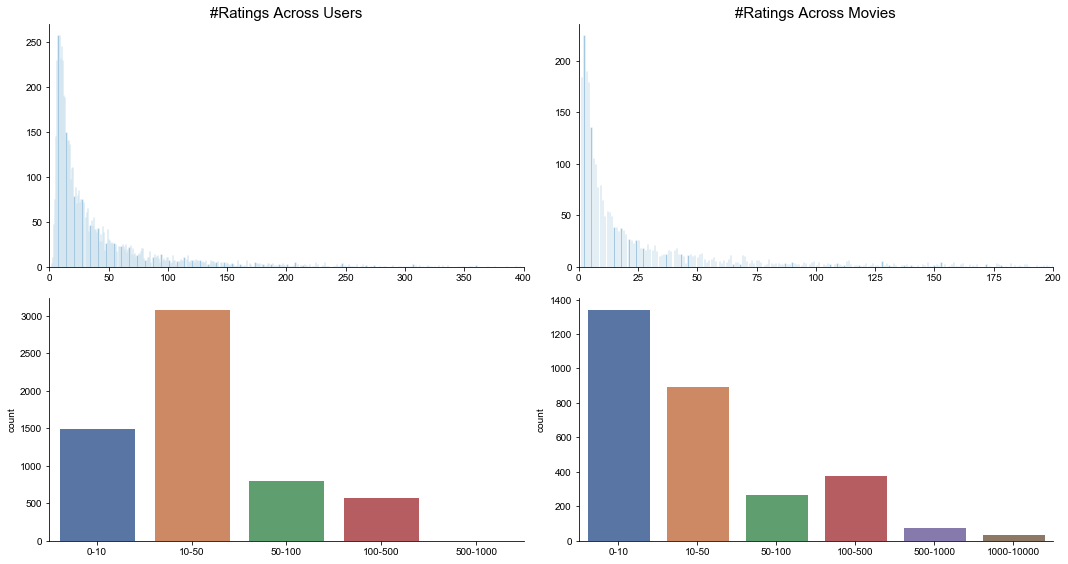

In [11]:
plot_df(user_freq_sample, movie_freq_sample, user_cnt_sample, movie_cnt_sample, user_grouped_sample, movie_grouped_sample)

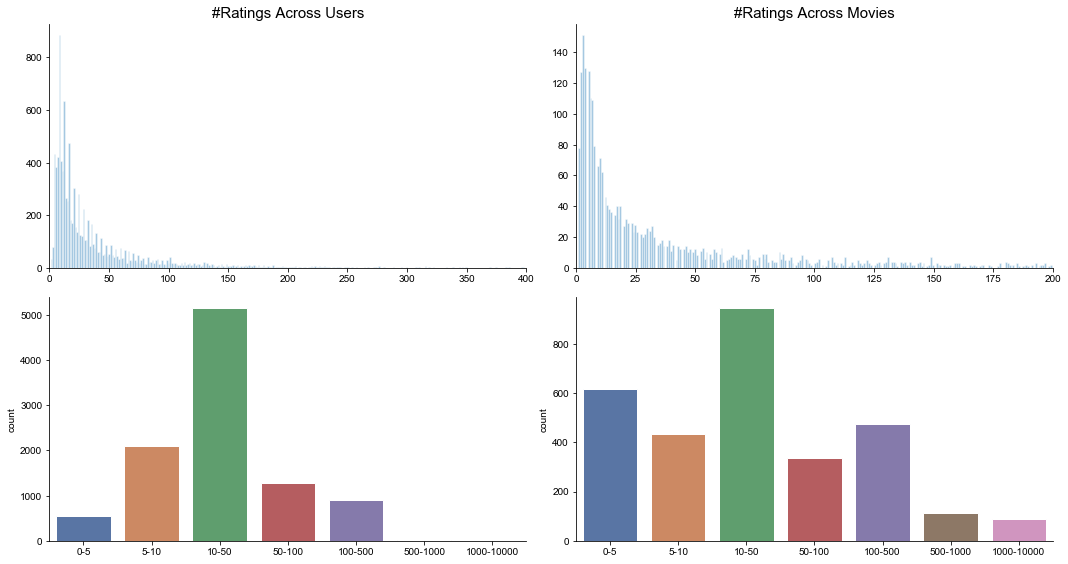

In [11]:
plot_df(user_freq_sample, movie_freq_sample, user_cnt_sample, movie_cnt_sample, user_grouped_sample, movie_grouped_sample)

# Grid Search

In [9]:
tag_cos = SimRank.tag_simrank()
tag_jac = SimRank.tag_simrank()
wbs = SimRank.weighted_bipartite_simrank()
cf = BenchMark.cf_recommendation()

In [10]:
C_item = C_user = 0.9
tag_relevance_cut_off = [0.1, 0.2, 0.3, 0.4, 0.5]
lambdas = [0.9, 0.7]
k_neighbors = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
k_matric = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
cf.fit(
    rating_train
)
tag_cos.fit(
    rating_train, 
    tags, 
    C_item = C_item, 
    C_user = C_user, 
    lbd = 0.9
)
tag_jac.fit(
    rating_train, 
    tags[tags.relevance > 0.1], 
    C_item = C_item, 
    C_user = C_user, 
    lbd = 0.9
)
wbs.fit(
    rating_train, 
    C_item = C_item, 
    C_user = C_user
)

User count: 5998, item count: 2969
Initializing tab-based item similarity matrix...
Finished in 1237.3672091960907s!
Initializing user-W matrix...
Finished in 5.472320079803467s!
Initializing item-W matrix...
Finished in 2.8873887062072754s!
Initializing user evidence matrix...
Finished in 1936.9979839324951s!
Initializing item evidence matrix...
Finished in 841.0911021232605s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 5.697974681854248, S_item updated in 6.1964991092681885!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 5.32213020324707, S_item updated in 5.836735010147095!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 5.315129995346069, S_item updated in 5.572631120681763!
Converged at iteration 3, break!
User count: 5998, item count: 2969
Initializing tab-based item similarity matrix...
Finished in 1213.3232591152191s!
Initializing user-W matrix...
Finished in 5.250339031219482s!
Initializing item

In [19]:
with open('grid_search_reversed_rst.pkl', 'rb') as f:
    records = pkl.load(f)

In [25]:
C_item = C_user = 0.9
tag_relevance_cut_off = [0.1, 0.2, 0.3, 0.4]
lambdas = [0.9, 0.7]
k_neighbors = [100]
k_matric = [5]

In [26]:
grid_records = []

In [13]:
import pickle as pkl

In [27]:
for lbd in lambdas:
    S_user, S_item = tag_cos._cal_S(C_user, C_item, lbd, 100, 1e-4, GPU = False)
    tag_cos.S_item = pd.DataFrame(S_item, index = tag_cos.items, columns = tag_cos.items)
    tag_cos.S_user = pd.DataFrame(S_user, index = tag_cos.users, columns = tag_cos.users)
    
    for cutoff in tag_relevance_cut_off:
        tag_jac.S_tag_based = tag_jac._cal_tab_based_S(tags[tags.relevance > cutoff], how = 'jac', GPU = False)
        
        S_user, S_item = tag_jac._cal_S(C_user, C_item, lbd, 100, 1e-4, GPU = False)
        tag_jac.S_item = pd.DataFrame(S_item, index = tag_jac.items, columns = tag_jac.items)
        tag_jac.S_user = pd.DataFrame(S_user, index = tag_jac.users, columns = tag_jac.users)
            
        for k in k_neighbors:
            pred_tag_cos = tag_cos.cf_recommendation(rating_test, k = k)
            pred_tag_jac = tag_jac.cf_recommendation(rating_test, k = k)
            pred_wbs = wbs.cf_recommendation(rating_test, k = k)
            pred_cf = cf.predict(rating_test, k = k)
            
            for n in k_matric:
                precision_tag_cos, recall_tag_cos, ndcg_tag_cos = evaluation.evaluation_at_k(
                    rating_test,
                    pred_tag_cos,
                    user_grouped = user_grouped_sample,
                    k = n
                )
                group_precision_tag_cos = evaluation.precision_over_user_group(
                    rating_test,
                    pred_tag_cos,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                group_recall_tag_cos = evaluation.recall_over_user_group(
                    rating_test,
                    pred_tag_cos,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                
                precision_tag_jac, recall_tag_jac, ndcg_tag_jac = evaluation.evaluation_at_k(
                    rating_test,
                    pred_tag_jac,
                    user_grouped = user_grouped_sample,
                    k = n
                )
                group_precision_tag_jac = evaluation.precision_over_user_group(
                    rating_test,
                    pred_tag_jac,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                group_recall_tag_jac = evaluation.recall_over_user_group(
                    rating_test,
                    pred_tag_jac,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                
                precision_wbs, recall_wbs, ndcg_wbs = evaluation.evaluation_at_k(
                    rating_test,
                    pred_wbs,
                    user_grouped = user_grouped_sample,
                    k = n
                )
                group_precision_wbs = evaluation.precision_over_user_group(
                    rating_test,
                    pred_wbs,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                group_recall_wbs = evaluation.recall_over_user_group(
                    rating_test,
                    pred_wbs,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                
                precision_cf, recall_cf, ndcg_cf = evaluation.evaluation_at_k(
                    rating_test,
                    pred_cf,
                    user_grouped = user_grouped_sample,
                    k = n
                )
                group_precision_cf = evaluation.precision_over_user_group(
                    rating_test,
                    pred_cf,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )
                group_recall_cf = evaluation.recall_over_user_group(
                    rating_test,
                    pred_cf,
                    user_grouped_sample,
                    k = n,
                    plot=False
                )

                grid_records.append({
                    'lbd': lbd,
                    'cutoff': cutoff, 
                    'k_neighbors': k,
                    'k_matric': n,
                    'precision_tag_cos': precision_tag_cos,
                    'recall_tag_cos': recall_tag_cos,
                    'ndcg_tag_cos': ndcg_tag_cos,
                    'precision_tag_jac': precision_tag_jac,
                    'recall_tag_jac': recall_tag_jac,
                    'ndcg_tag_jac': ndcg_tag_jac,
                    'precision_wbs': precision_wbs,
                    'recall_wbs': recall_wbs,
                    'ndcg_wbs': ndcg_wbs,
                    'precision_cf': precision_cf,
                    'recall_cf': recall_cf,
                    'ndcg_cf': ndcg_cf,
                    'group_precision_tag_cos': group_precision_tag_cos,
                    'group_recall_tag_cos': group_recall_tag_cos,
                    'group_precision_tag_jac': group_precision_tag_jac,
                    'group_recall_tag_jac': group_recall_tag_jac,
                    'group_precision_wbs': group_precision_wbs,
                    'group_recall_wbs': group_recall_wbs,
                    'group_precision_cf': group_precision_cf,
                    'group_recall_cf': group_recall_cf
                })
                with open('grid_search_reversed_rst_new.pkl', 'wb') as f:
                    pkl.dump(grid_records, f)

Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 9.61676812171936, S_item updated in 11.80438780784607!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 6.548719167709351, S_item updated in 9.065470218658447!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 7.86392068862915, S_item updated in 8.100135087966919!
Converged at iteration 3, break!
Initializing tab-based item similarity matrix...
Finished in 1473.244750738144s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 8.629357814788818, S_item updated in 10.81891918182373!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 7.523247957229614, S_item updated in 7.94825291633606!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 7.5779008865356445, S_item updated in 7.795448064804077!
Converged at iteration 3, break!
Count of cold start user: 2
Count of cold start item: 45
557/5567 completed

GPU failed, trying with CPU...
S_user updated in 8.058918714523315, S_item updated in 5.966815948486328!
Iteration 4 / 100 start:
GPU failed, trying with CPU...
S_user updated in 5.521528720855713, S_item updated in 6.566065311431885!
Converged at iteration 4, break!
Count of cold start user: 2
Count of cold start item: 45
557/5567 completed
1114/5567 completed
1671/5567 completed
2227/5567 completed
2784/5567 completed
3341/5567 completed
3897/5567 completed
4454/5567 completed
5011/5567 completed
5567/5567 completed
Count of cold start user: 2
Count of cold start item: 45
557/5567 completed
1114/5567 completed
1671/5567 completed
2227/5567 completed
2784/5567 completed
3341/5567 completed
3897/5567 completed
4454/5567 completed
5011/5567 completed
5567/5567 completed
Count of cold start user: 2
Count of cold start item: 45
557/5567 completed
1114/5567 completed
1671/5567 completed
2227/5567 completed
2784/5567 completed
3341/5567 completed
3897/5567 completed
4454/5567 completed
5011

KeyboardInterrupt: 

In [ ]:
print(1)

In [20]:
rst = pd.DataFrame(records)

In [21]:
rst.head()

,lbd,cutoff,k_neighbors,k_matric,precision_tag_cos,recall_tag_cos,ndcg_tag_cos,precision_tag_jac,recall_tag_jac,ndcg_tag_jac,precision_wbs,recall_wbs,ndcg_wbs,precision_cf,recall_cf,ndcg_cf
0,0.3,0.1,20,1,0.188641,0.034804,0.188641,0.206463,0.039091,0.206463,0.149023,0.031627,0.149023,0.295577,0.049581,0.295577
1,0.3,0.1,20,5,0.113528,0.095123,0.148920,0.122890,0.102894,0.161578,0.086601,0.085264,0.118485,0.186064,0.138767,0.235263
2,0.3,0.1,20,10,0.078881,0.134365,0.144076,0.087685,0.144471,0.157539,0.062433,0.123220,0.120545,0.139306,0.192512,0.227535
3,0.3,0.1,40,1,0.228473,0.042981,0.228473,0.240391,0.045932,0.240391,0.186171,0.039071,0.186171,0.318660,0.054899,0.318660
4,0.3,0.1,40,5,0.129268,0.112458,0.173597,0.137062,0.118950,0.183609,0.105239,0.101562,0.144665,0.196607,0.149918,0.251673


In [27]:
import pickle as pkl
with open('data_rst_thresh0.pkl', 'wb') as f:
    pkl.dump([rating_train, rating_test], f)

# TagSimRank

In [6]:
# Init instance
tsr_jac = SimRank.tag_simrank()

In [7]:
# train
tsr_jac.fit(rating_train, tags, C_item = 0.8, C_user = 0.8, lbd = 0.3, iterations = 100, eps = 1e-4, how = 'jac')

User count: 2000, item count: 200
Initializing tab-based item similarity matrix...
Finished in 57.44846701622009s!
Initializing user-W matrix...
Finished in 0.05762505531311035s!
Initializing item-W matrix...
Finished in 0.013184070587158203s!
Initializing user evidence matrix...
Finished in 0.9871296882629395s!
Initializing item evidence matrix...
Finished in 1.6995220184326172s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03543686866760254, S_item updated in 0.06458497047424316!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.0403141975402832, S_item updated in 0.07179594039916992!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.045787811279296875, S_item updated in 0.05073094367980957!
Converged at iteration 3, break!


In [8]:
# predict
tsr_jac_pred = tsr_jac.cf_recommendation(rating_test)

Count of cold start user: 0
Count of cold start item: 0
191/1906 completed
382/1906 completed
572/1906 completed
763/1906 completed
953/1906 completed
1144/1906 completed
1335/1906 completed
1525/1906 completed
1716/1906 completed
1906/1906 completed


In [9]:
user_grouped = evaluation.group(rating_test, 'user')

In [10]:
# Evaluation
tsr_precision = evaluation.precision_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
tsr_recall = evaluation.recall_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
tsr_ndcg = evaluation.ndcg_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

Precision: 0.07177334732423926
Recall: 0.20688978882840373
ndcg: 0.16541804108139532


In [ ]:
# aggrate evaluation
precision, recall, ndcg = evaluation.evaluation_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)

Recall for each user group:  {'0-5': 0.0584, '5-10': 0.1335, '10-50': 0.232}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


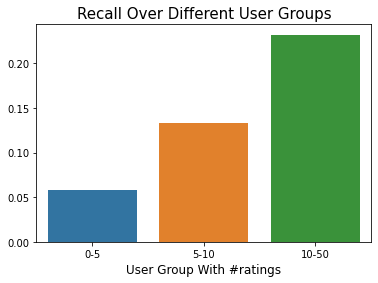

{'0-5': 0.0584, '5-10': 0.1335, '10-50': 0.232}

In [11]:
evaluation.precision_over_user_group(rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped)

Recall for each user group:  {'0-5': 0.2096, '5-10': 0.1939, '10-50': 0.1815}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


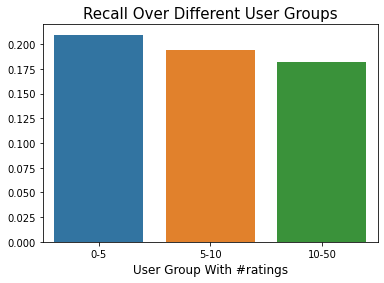

{'0-5': 0.2096, '5-10': 0.1939, '10-50': 0.1815}

In [12]:
evaluation.recall_over_user_group(rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped)

In [13]:
# Evaluation
tsr_precision = evaluation.precision_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
tsr_recall = evaluation.recall_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
tsr_ndcg = evaluation.ndcg_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

Precision: 0.10493204283360792
Recall: 0.17899064676510162
Recall: 0.17582168273247448


# Weighted Bipartite SimRank

In [13]:
# Init instance
wbs = SimRank.weighted_bipartite_simrank()

In [14]:
wbs.fit(rating_train)

User count: 2000, item count: 200
Initializing user-W matrix...
Finished in 0.05991005897521973s!
Initializing item-W matrix...
Finished in 0.013983964920043945s!
Initializing user evidence matrix...
Finished in 1.1156260967254639s!
Initializing item evidence matrix...
Finished in 1.743818998336792s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03458380699157715, S_item updated in 0.06656098365783691!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03442811965942383, S_item updated in 0.07073688507080078!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.055589914321899414, S_item updated in 0.05883431434631348!
Converged at iteration 3, break!


In [15]:
wbs_pred = wbs.cf_recommendation(rating_test)

Count of cold start user: 0
Count of cold start item: 0
191/1906 completed
382/1906 completed
572/1906 completed
763/1906 completed
953/1906 completed
1144/1906 completed
1335/1906 completed
1525/1906 completed
1716/1906 completed
1906/1906 completed


In [16]:
# Evaluation
wbs_precision = evaluation.precision_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"Precision: {wbs_precision}")
wbs_recall = evaluation.recall_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"Recall: {wbs_recall}")
wbs_ndcg = evaluation.ndcg_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {wbs_ndcg}")

Precision: 0.07738719832109131
Recall: 0.21940910902086141
ndcg: 0.1733192177928342


Recall for each user group:  {'0-5': 0.0622, '5-10': 0.148, '10-50': 0.256}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


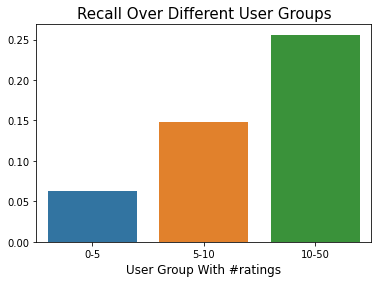

{'0-5': 0.0622, '5-10': 0.148, '10-50': 0.256}

In [17]:
evaluation.precision_over_user_group(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped)

Recall for each user group:  {'0-5': 0.2203, '5-10': 0.2157, '10-50': 0.2015}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


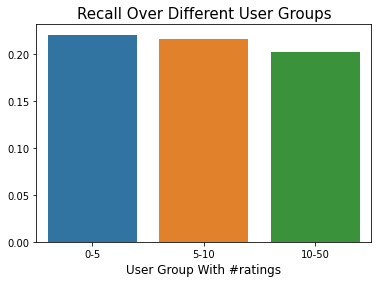

{'0-5': 0.2203, '5-10': 0.2157, '10-50': 0.2015}

In [18]:
evaluation.recall_over_user_group(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped)